## Prep to run this notebook:
- scripts/run_vk_ref_geuvadis.py
- scripts/run_vk_count_geuvadis.py
- scripts/run_vk_count_geuvadis_wxs.py

In [75]:
# try:
#     import varseek as vk
# except ImportError:
#     print("varseek not found, installing...")
#     !pip install -U -q varseek
# try:
#     import RLSRP_2025
# except ImportError:
#     print("RLSRP_2025 not found, installing...")
#     !pip install -q git+https://github.com/pachterlab/RLSRP_2025.git

In [76]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import seaborn as sns
import re
import anndata as ad
from upsetplot import UpSet, from_contents

import varseek as vk
from RLSRP_2025.constants import box_links_dict

RLSRP_2025_dir = os.path.dirname(os.path.abspath(""))  # if this notebook resides in RLSRP_2025/notebooks/0_data_download.ipynb, then this retrieves RLSRP_2025
data_dir = os.path.join(RLSRP_2025_dir, "data")

In [ ]:
sequencing_data_out_base = os.path.join(data_dir, "geuvadis_data_base")
geuvadis_reference_files_dir = os.path.join(data_dir, "reference", "geuvadis")
variants_transcriptome_df_path = os.path.join(geuvadis_reference_files_dir, "variants_transcriptome.parquet")
reference_genome_t2g = os.path.join(data_dir, "reference", "ensembl_grch37_release113", "t2g.txt")

geuvadis_genotype_true_adata = os.path.join(geuvadis_reference_files_dir, "genotypes_adata_true.h5ad")
adata_combined_path_reference_genome = os.path.join(sequencing_data_out_base, "adata_reference_genome_combined.h5ad")

w_and_k_list_of_dicts = [
    {"w": 27, "k": 31},
    {"w": 37, "k": 41},
    {"w": 47, "k": 51},
]

experiment_accession = "E_GEUV_1_HG00377_1_M_120209_6"  # experiment_accession to focus on
min_counts = 2
gene_set_to_exclude = {'ENSG00000111640', 'ENSG00000242580', 'ENSG00000243466', 'ENST00000603632', 'ENST00000605760'}  # None, or a set of gene names to exclude from the analysis (in ENSGs)

out_dir = os.path.join(data_dir, "geuvadis_analysis_supplement", experiment_accession)

In [78]:
if not os.path.isfile(adata_combined_path_reference_genome):
    vk.utils.download_box_url(box_links_dict["geuvadis_adata_reference_genome"], output_file_name=adata_combined_path_reference_genome)
if not os.path.isfile(geuvadis_genotype_true_adata):
    vk.utils.download_box_url(box_links_dict["geuvadis_adata_genotype"], output_file_name=geuvadis_genotype_true_adata)

adata_reference = ad.read_h5ad(adata_combined_path_reference_genome)
adata_genotype = ad.read_h5ad(geuvadis_genotype_true_adata)

os.makedirs(out_dir, exist_ok=True)

In [79]:
if not os.path.isfile(variants_transcriptome_df_path):
    vk.utils.download_box_url(box_links_dict["geuvadis_variants"], output_file_name=variants_transcriptome_df_path)

variants_transcriptome_df = pd.read_parquet(variants_transcriptome_df_path)
variants_transcriptome_df['variant_header_cdna'] = variants_transcriptome_df['transcript_ID'] + ":" + variants_transcriptome_df['variant_cdna']
adata_genotype.var = adata_genotype.var.merge(variants_transcriptome_df[["variant_header", "variant_header_cdna"]], how="left", on="variant_header")
adata_genotype.var.rename(columns={"variant_header": "variant_header_cds", "variant_header_cdna": "variant_header"}, inplace=True)
adata_genotype.var.index = adata_genotype.var.index.astype(str)  # otherwise I get AssertionError: Don’t call _normalize_index with non-categorical/string names
adata_genotype.obs.index = adata_genotype.obs.index.astype(str)
adata_genotype.obs['sample_title'] = adata_genotype.obs.index.astype(str).str.slice(2)

adata_reference.var['gene'] = adata_reference.var.index.str.split(".").str[0]
t2g_dict = vk.utils.make_t2g_dict(reference_genome_t2g)
t2g_dict = {key.split(".")[0]: val.split(".")[0] for key, val in t2g_dict.items()}  # strip off the version number

/home/jmrich/Desktop/varseek/varseek/utils/varseek_clean_utils.py:2277: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  t2g_df = pd.read_csv(t2g_file, sep="\t", header=None)


In [80]:
adata_genotype.var.head()

,has_id,ID,variant_header_cds,variant_header
0,True,rs200036735,ENST00000327044.6:c.106C>T,ENST00000327044:c.156C>T
1,True,rs201791495,ENST00000327044.6:c.57C>T,ENST00000327044:c.107C>T
2,True,rs192245893,ENST00000338591.3:c.90A>C,ENST00000338591:c.197A>C
3,True,rs200516692,ENST00000338591.3:c.163G>A,ENST00000338591:c.270G>A
4,True,rs199679371,ENST00000338591.3:c.189G>A,ENST00000338591:c.296G>A


In [81]:
# vcf = pd.read_parquet("/home/jmrich/Desktop/RLSRP_2025/data/reference/geuvadis/1kg_phase1_all_preliminary_vcf_exons.parquet")
# vcf.head()

## Plot Venn diagrams for my k-series to determine the best variant matrix to use

In [82]:
# import pysam
# import pandas as pd

# vcf_path_preliminary = "/home/jmrich/Desktop/RLSRP_2025/data/reference/geuvadis/1kg_phase1_all_preliminary_exons.vcf.gz"
# vcf_path_true = "/home/jmrich/Desktop/RLSRP_2025/data/reference/geuvadis/1kg_phase1_all_true.vcf.gz"
# sample = "0_HG00377"

# vcf_preliminary = pysam.VariantFile(vcf_path_preliminary)
# vcf_true = pysam.VariantFile(vcf_path_true)

# # Check sample names
# if sample not in vcf_preliminary.header.samples:
#     raise ValueError("Sample sample not found in VCF")

# variants_possessed_by_this_sample = set()
# for rec_preliminary, rec_true in zip(vcf_preliminary, vcf_true):
#     if rec_preliminary.ref == rec_true.ref:
#         sample_homozygous_ref = rec_preliminary.samples[sample].get("GT") == (0, 0)
#     else:
#         sample_homozygous_ref = rec_preliminary.samples[sample].get("GT") == (1, 1)
#     if not sample_homozygous_ref:
#         variants_possessed_by_this_sample.add(rec_preliminary.id)


k=31
Sample HG00327
Number of variants in varseek_rna: 1801
Number of variants in geuvadis_dna: 4721
Number of variants_all: 179817
Note: for the calculations below, we consider geuvadis_dna as the 'ground truth' and varseek_rna as the 'predicted set'.
Number of TP: 1381
Number of FP: 420
Number of FN: 3340
Number of TN: 174676
Accuracy: 0.979
Sensitivity: 0.293
Specificity: 0.998


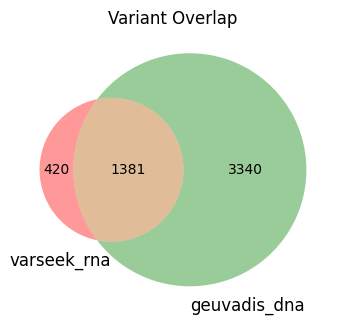

------------------------
k=41
Sample HG00327
Number of variants in varseek_rna: 1733
Number of variants in geuvadis_dna: 4641
Number of variants_all: 178509
Note: for the calculations below, we consider geuvadis_dna as the 'ground truth' and varseek_rna as the 'predicted set'.
Number of TP: 1370
Number of FP: 363
Number of FN: 3271
Number of TN: 173505
Accuracy: 0.980
Sensitivity: 0.295
Specificity: 0.998


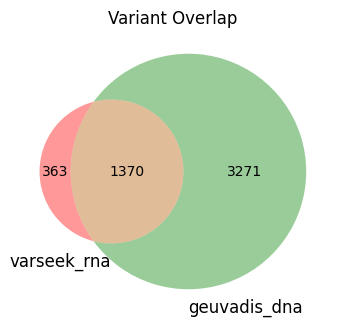

------------------------
k=51
Sample HG00327
Number of variants in varseek_rna: 24
Number of variants in geuvadis_dna: 142
Number of variants_all: 1652
Note: for the calculations below, we consider geuvadis_dna as the 'ground truth' and varseek_rna as the 'predicted set'.
Number of TP: 13
Number of FP: 11
Number of FN: 129
Number of TN: 1499
Accuracy: 0.915
Sensitivity: 0.092
Specificity: 0.993


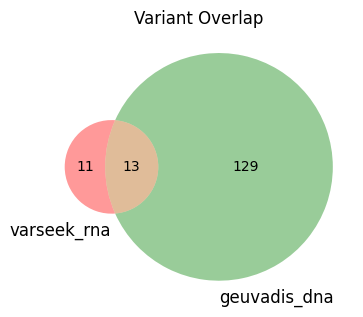

------------------------


In [74]:
# TODO: I currently ran vk ref with merge_identical=False, but in the future, I would like to do this with True, resolve merged headers with reference genome alignment, and then filter out whichever merged headers remain
def plot_variant_overlap(adata_vcrs_path, adata_genotype_path, experiment_accession=None, min_counts=None, out_path=None, upset_out_path=None, gene_set_to_exclude=None, t2g_dict=None):
    if isinstance(adata_vcrs_path, str):
        adata_vcrs = ad.read_h5ad(adata_vcrs_path)
    elif isinstance(adata_vcrs_path, ad.AnnData):
        adata_vcrs = adata_vcrs_path.copy()
    else:
        raise ValueError("adata_vcrs_path must be a string or an AnnData object.")
    if "vcrs_header" in adata_vcrs.var.columns:
        adata_vcrs.var["variant_header"] = adata_vcrs.var["vcrs_header"].copy()
    if "variant_header" not in adata_vcrs.var.columns:
        adata_vcrs.var["variant_header"] = adata_vcrs.var.index.copy()

    if isinstance(adata_genotype_path, str):
        adata_genotype = ad.read_h5ad(adata_genotype_path)
    elif isinstance(adata_genotype_path, ad.AnnData):
        adata_genotype = adata_genotype_path.copy()
    else:
        raise ValueError("adata_genotype_path must be a string or an AnnData object.")
    
    # keep only the columns in adata_genotype that are also in adata_vcrs
    shared_headers = adata_genotype.var["variant_header"].isin(adata_vcrs.var["variant_header"].unique())
    adata_genotype = adata_genotype[:, shared_headers].copy()
    
    # Select only the sample_index'th sample
    sample_index = int(adata_vcrs.obs.index[adata_vcrs.obs["experiment_alias_underscores_only"] == experiment_accession].values[0])
    sample_title = adata_vcrs.obs.iloc[sample_index]['sample_title']
    print(f"Sample {sample_title}")
    adata_genotype.obs.index = adata_genotype.obs.index.astype(str)
    adata_genotype.obs['sample_title'] = adata_genotype.obs.index.copy().str.slice(2)
    if sample_title not in set(adata_genotype.obs['sample_title']):
        raise ValueError(f"Sample title {sample_title} not found in adata_genotype.")
    
    adata_vcrs = adata_vcrs[sample_index, :]
    adata_genotype = adata_genotype[adata_genotype.obs['sample_title'] == sample_title].copy()

    if min_counts is not None:
        adata_vcrs.X = adata_vcrs.X.multiply(adata_vcrs.X >= min_counts)
    
    if gene_set_to_exclude is not None:
        gene_set_to_exclude = set(gene_set_to_exclude)
        adata_vcrs.var = adata_vcrs.var.merge(variants_transcriptome_df[['variant_header_cdna', 'transcript_ID']], how="left", left_index=True, right_on="variant_header_cdna").reset_index(drop=True)
        adata_vcrs.var["gene"] = adata_vcrs.var["transcript_ID"].map(t2g_dict)

        adata_genotype.var = adata_genotype.var.merge(variants_transcriptome_df[['variant_header_cdna', 'transcript_ID']], how="left", left_on="variant_header", right_on="variant_header_cdna").reset_index(drop=True)
        adata_genotype.var["gene"] = adata_genotype.var["transcript_ID"].map(t2g_dict)

        adata_vcrs.var.index = adata_vcrs.var.index.astype(str)
        adata_genotype.var.index = adata_genotype.var.index.astype(str)

        # do it for both transcript IDs and gene names
        adata_vcrs = adata_vcrs[:, ~adata_vcrs.var['transcript_ID'].isin(gene_set_to_exclude).values]
        adata_vcrs = adata_vcrs[:, ~adata_vcrs.var['gene'].isin(gene_set_to_exclude).values]
        adata_genotype = adata_genotype[:, ~adata_genotype.var['transcript_ID'].isin(gene_set_to_exclude).values]
        adata_genotype = adata_genotype[:, ~adata_genotype.var['gene'].isin(gene_set_to_exclude).values]
        
    
    variants_all = set(adata_vcrs.var["variant_header"])

    # Filter adata_vcrs: keep only columns where the value in the first row is not 0
    nonzero_vcrs_cols = adata_vcrs.X[0] > 0
    adata_vcrs = adata_vcrs[:, nonzero_vcrs_cols]
    variants_predicted = set(adata_vcrs.var["variant_header"])

    # Filter adata_genotype: keep only columns where the value in the first row is not 0
    nonzero_genotype_cols = adata_genotype.X[0] > 0
    adata_genotype = adata_genotype[:, nonzero_genotype_cols]
    variants_true = set(adata_genotype.var["variant_header"])

    # ensure no version numbers on Ensembl transcript IDs
    variants_predicted = {re.sub(r'(ENST\d+)\.\d+', r'\1', v) for v in variants_predicted}
    variants_true = {re.sub(r'(ENST\d+)\.\d+', r'\1', v) for v in variants_true}

    # print(f"First 100 variants_true: {sorted(list(variants_true))[:100]}")
    # print(f"First 100 variants_predicted: {sorted(list(variants_predicted))[:100]}")

    TP = len(variants_predicted & variants_true)
    FP = len(variants_predicted - variants_true)
    FN = len(variants_true - variants_predicted)
    TN = len(variants_all - variants_true - variants_predicted)

    global dict_of_fp_and_fn
    dict_of_fp_and_fn[f"w{w}_k{k}"] = {}
    dict_of_fp_and_fn[f"w{w}_k{k}"]["FP"] = variants_predicted - variants_true
    dict_of_fp_and_fn[f"w{w}_k{k}"]["FN"] = variants_true - variants_predicted
    # print(f"First 100 FP: {sorted(list(variants_predicted - variants_true))[:100]}")
    # print(f"First 100 FN: {sorted(list(variants_true - variants_predicted))[:100]}")

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) else 0
    specificity = TN / (TN + FP) if (TN + FP) else 0

    print(f"Number of variants in varseek_rna: {len(variants_predicted)}")
    print(f"Number of variants in geuvadis_dna: {len(variants_true)}")
    print(f"Number of variants_all: {len(variants_all)}")
    print("Note: for the calculations below, we consider geuvadis_dna as the 'ground truth' and varseek_rna as the 'predicted set'.")
    print(f"Number of TP: {TP}")
    print(f"Number of FP: {FP}")
    print(f"Number of FN: {FN}")
    print(f"Number of TN: {TN}")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Sensitivity: {sensitivity:.3f}")
    print(f"Specificity: {specificity:.3f}")

    plt.figure(figsize=(4, 4))
    venn2([variants_predicted, variants_true], set_labels=('varseek_rna', 'geuvadis_dna'))  # "Varseek RNA", "Geuvadis DNA"
    plt.title("Variant Overlap")
    if out_path:
        plt.savefig(out_path, dpi=300)
    plt.show()
    plt.close()

    upset_dict = {
        "varseek_rna": variants_predicted,
        "geuvadis_dna": variants_true,
    }
    variants_detected_data_for_upset = from_contents(upset_dict)
    ax_dict = UpSet(variants_detected_data_for_upset, subset_size='count', show_counts=True).plot()
    plt.savefig(upset_out_path)
    plt.close()

dict_of_fp_and_fn = {}
for w_and_k_dict in w_and_k_list_of_dicts:
    w, k = w_and_k_dict["w"], w_and_k_dict["k"]
    adata_combined_path_vcrs = os.path.join(sequencing_data_out_base, f"adata_vcrs_combined_w{w}_k{k}.h5ad")
    if not os.path.isfile(adata_combined_path_vcrs):
        vk.utils.download_box_url(box_links_dict[f"geuvadis_adata_vcrs_w{w}_k{k}"], output_file_name=adata_combined_path_vcrs)
    
    print(f"k={k}")
    venn_out_path = os.path.join(out_dir, f"variant_overlap_sample_{experiment_accession}_w{w}_k{k}.pdf")
    upset_out_path = os.path.join(out_dir, f"upset_variant_overlap_k_test_sample_{experiment_accession}_w{w}_k{k}.pdf")
    plot_variant_overlap(adata_combined_path_vcrs, adata_genotype, out_path=venn_out_path, upset_out_path=upset_out_path, experiment_accession=experiment_accession, min_counts=min_counts, gene_set_to_exclude=gene_set_to_exclude, t2g_dict=t2g_dict)
    print("------------------------")

    # break

## Based on this, I will choose k=41

In [ ]:
w, k = 37, 41
adata_combined_path_vcrs_final = os.path.join(sequencing_data_out_base, f"adata_vcrs_combined_w{w}_k{k}.h5ad")
if not os.path.isfile(adata_combined_path_vcrs_final):
    vk.utils.download_box_url(box_links_dict[f"geuvadis_adata_vcrs_w{w}_k{k}"], output_file_name=adata_combined_path_vcrs_final)

adata_vcrs = ad.read_h5ad(adata_combined_path_vcrs_final)
if min_counts is not None:
    adata_vcrs.X = adata_vcrs.X.multiply(adata_vcrs.X >= min_counts)

if "vcrs_count" not in adata_vcrs.var.columns:
    adata_vcrs.var["vcrs_count"] = adata_vcrs.X.sum(axis=0).A1 if hasattr(adata_vcrs.X, "A1") else np.asarray(adata_vcrs.X.sum(axis=0)).flatten()

adata_vcrs.var = adata_vcrs.var.merge(variants_transcriptome_df[['variant_header', 'variant_header_cdna', 'transcript_ID']], how="left", left_index=True, right_on="variant_header_cdna").reset_index(drop=True)
adata_vcrs.var.rename(columns={"variant_header": "variant_header_cds", "variant_header_cdna": "variant_header", "vcrs_count": "variant_count"}, inplace=True)

# keep only the columns in adata_genotype that are also in adata_vcrs
shared_headers = adata_genotype.var["variant_header"].isin(adata_vcrs.var["variant_header"].unique())
adata_genotype = adata_genotype[:, shared_headers].copy()

adata_vcrs.var["gene"] = adata_vcrs.var["transcript_ID"].map(t2g_dict)

if gene_set_to_exclude is not None:
    gene_set_to_exclude = set(gene_set_to_exclude)

    adata_genotype.var = adata_genotype.var.merge(variants_transcriptome_df[['variant_header_cdna', 'transcript_ID']], how="left", left_on="variant_header", right_on="variant_header_cdna").reset_index(drop=True)
    adata_genotype.var["gene"] = adata_genotype.var["transcript_ID"].map(t2g_dict)

    adata_vcrs.var.index = adata_vcrs.var.index.astype(str)
    adata_genotype.var.index = adata_genotype.var.index.astype(str)

    # do it for both transcript IDs and gene names
    adata_vcrs = adata_vcrs[:, ~adata_vcrs.var['transcript_ID'].isin(gene_set_to_exclude).values]
    adata_vcrs = adata_vcrs[:, ~adata_vcrs.var['gene'].isin(gene_set_to_exclude).values]
    adata_genotype = adata_genotype[:, ~adata_genotype.var['transcript_ID'].isin(gene_set_to_exclude).values]
    adata_genotype = adata_genotype[:, ~adata_genotype.var['gene'].isin(gene_set_to_exclude).values]

In [ ]:
# only if naming discrepency
if "." in adata_reference.obs['experiment_alias_underscores_only'].iloc[0] or ":" in adata_reference.obs['experiment_alias_underscores_only'].iloc[0]:
    adata_reference.obs['experiment_alias_underscores_only'] = (
        adata_reference.obs['experiment_alias_underscores_only']
        .str.replace(r'[.:]', '_', regex=True)
    )

In [ ]:
# print(adata_vcrs.var.sort_values('vcrs_count', ascending=False))
sample_index = int(adata_vcrs.obs.index[adata_vcrs.obs["experiment_alias_underscores_only"] == experiment_accession].values[0])
sample_title, experiment_alias_underscores_only = adata_vcrs.obs.iloc[sample_index]['sample_title'], adata_vcrs.obs.iloc[sample_index]['experiment_alias_underscores_only']
adata_vcrs_single_sample = adata_vcrs[adata_vcrs.obs['experiment_alias_underscores_only'].isin({experiment_alias_underscores_only})].copy()
adata_vcrs_single_sample.var["variant_count"] = adata_vcrs_single_sample.X.sum(axis=0).A1 if hasattr(adata_vcrs_single_sample.X, "A1") else np.asarray(adata_vcrs_single_sample.X.sum(axis=0)).flatten()

adata_reference_single_sample = adata_reference[adata_reference.obs['experiment_alias_underscores_only'].isin({experiment_alias_underscores_only})].copy()
adata_reference_single_sample.var['gene_count'] = adata_reference_single_sample.X.toarray().flatten()

adata_genotype_single_sample = adata_genotype[adata_genotype.obs['sample_title'].isin({sample_title})].copy()
adata_genotype_single_sample.var['genotype'] = adata_genotype_single_sample.X.toarray().flatten()

adata_vcrs_single_sample.var = adata_vcrs_single_sample.var.merge(adata_reference_single_sample.var[["gene", "gene_count"]], how="left", on="gene")
adata_vcrs_single_sample.var = adata_vcrs_single_sample.var.merge(adata_genotype_single_sample.var[["variant_header", "genotype"]], how="left", on="variant_header")
adata_vcrs_single_sample.var.index = adata_vcrs_single_sample.var.index.astype(str)

# Save to file
fns_txt_path = os.path.join(out_dir, "fns.txt")
if not os.path.isfile(fns_txt_path):
    with open(fns_txt_path, "w") as f:
        for item in dict_of_fp_and_fn[f"w{w}_k{k}"]["FN"]:
            f.write(f"{item}\n")

fp_df = (
    adata_vcrs_single_sample.var.loc[
    adata_vcrs_single_sample.var['variant_header'].isin(dict_of_fp_and_fn[f"w{w}_k{k}"]["FP"])]
    .sort_values('variant_count', ascending=False)
)

fp_df_output_path = os.path.join(out_dir, "fp_df.parquet")
if not os.path.isfile(fp_df_output_path):
    fp_df.to_parquet(fp_df_output_path)
fp_df.head()

,variant_count,variant_header_cds,variant_header,transcript_ID,gene,gene_count,genotype
175075,1821.0,ENST00000390312.2:c.177G>A,ENST00000390312:c.218G>A,ENST00000390312,ENSG00000211666,5685.0,0.0
58568,722.0,ENST00000579721.1:c.142G>A,ENST00000579721:c.142G>A,ENST00000579721,NaN,NaN,0.0
128120,267.0,ENST00000603423.1:c.87G>A,ENST00000603423:c.137G>A,ENST00000603423,NaN,NaN,0.0
175059,184.0,ENST00000390309.2:c.319A>G,ENST00000390309:c.359A>G,ENST00000390309,ENSG00000211663,8520.0,0.0
128071,183.0,ENST00000603600.1:c.205G>A,ENST00000603600:c.285G>A,ENST00000603600,NaN,NaN,0.0


In [ ]:
genotype_value_to_string_mapping = {0: "homozygous_ref", 1: "heterozygous", 2: "homozygous_alt"}
for genotype_value, genotype_string in genotype_value_to_string_mapping.items():
    number_of_variants_with_this_genotype = len(adata_genotype_single_sample.var.loc[adata_genotype_single_sample.var['genotype'] == genotype_value])
    print(f"Number of variants in sample {sample_title} with genotype {genotype_string}: {number_of_variants_with_this_genotype}")

Number of variants in sample HG00377 with genotype homozygous_ref: 173848
Number of variants in sample HG00377 with genotype heterozygous: 3259
Number of variants in sample HG00377 with genotype homozygous_alt: 1391


In [ ]:
adata_vcrs_single_sample = adata_vcrs_single_sample[:, (adata_vcrs_single_sample.var['genotype'] > 0) & (adata_vcrs_single_sample.var['variant_count'] > 0) & (~adata_vcrs_single_sample.var['gene'].isna())].copy()
adata_vcrs_single_sample

AnnData object with n_obs × n_vars = 1 × 1306
    obs: 'experiment_alias_underscores_only', 'experiment_accession', 'library_strategy', 'sample_title', 'Sex', 'Biosample ID', 'Population name', 'Superpopulation name'
    var: 'variant_count', 'variant_header_cds', 'variant_header', 'transcript_ID', 'gene', 'gene_count', 'genotype'

In [ ]:
adata_vcrs_single_sample.var.head()

,variant_count,variant_header_cds,variant_header,transcript_ID,gene,gene_count,genotype
441,4.0,ENST00000355826.5:c.214T>C,ENST00000355826:c.253T>C,ENST00000355826,ENSG00000197530,158.0,2.0
590,40.0,ENST00000355716.4:c.50A>G,ENST00000355716:c.349A>G,ENST00000355716,ENSG00000157873,769.0,1.0
794,4.0,ENST00000378209.3:c.954A>G,ENST00000378209:c.1277A>G,ENST00000378209,ENSG00000169598,93.0,1.0
832,3.0,ENST00000378156.4:c.3570A>G,ENST00000378156:c.3836A>G,ENST00000378156,ENSG00000131697,82.0,1.0
1233,3.0,ENST00000377403.2:c.2019T>C,ENST00000377403:c.2321T>C,ENST00000377403,ENSG00000049239,715.0,1.0


## Scatterplot time

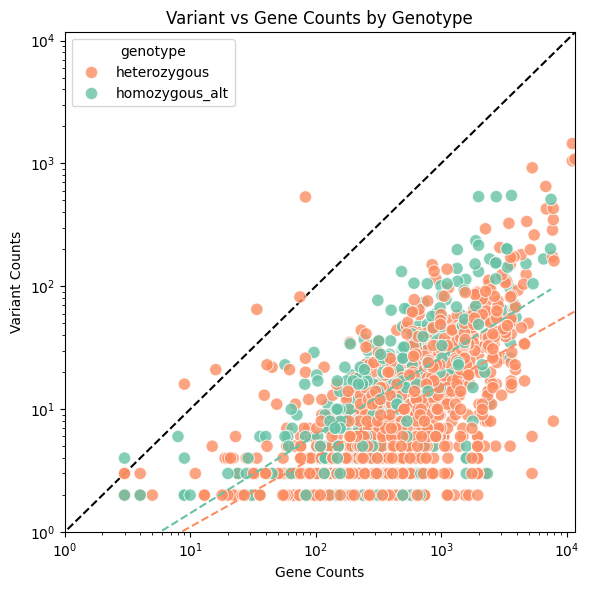

In [ ]:
from scipy.stats import linregress

scatterplot_df = adata_vcrs_single_sample.var[["variant_count", "gene_count", "genotype"]].copy()
scatterplot_df["genotype"] = scatterplot_df["genotype"].astype("category")
scatterplot_df["genotype"] = scatterplot_df["genotype"].cat.rename_categories({0: "homozygous_ref", 1: "heterozygous", 2: "homozygous_alt"})

scatterplot_df = scatterplot_df[(scatterplot_df["variant_count"] > 0) & (scatterplot_df["gene_count"] > 0)].copy()


# Use a consistent palette
palette = sns.color_palette("Set2")
genotypes = scatterplot_df["genotype"].unique()
genotype_colors = dict(zip(genotypes, palette))

plt.figure(figsize=(6, 6))
sns.scatterplot(
    data=scatterplot_df,
    y="variant_count",
    x="gene_count",
    hue="genotype",
    palette=genotype_colors,
    alpha=0.8,
    s=80  # adjust marker size
)

# Loop over each genotype
for genotype, group_df in scatterplot_df.groupby("genotype"):
    x_log = np.log10(group_df["gene_count"])
    y_log = np.log10(group_df["variant_count"])

    slope, intercept, r_value, p_value, std_err = linregress(x_log, y_log)

    x_vals = np.linspace(x_log.min(), x_log.max(), 100)
    y_vals = slope * x_vals + intercept

    label = f"{genotype} fit: $R^2={r_value**2:.2f}$"
    plt.plot(10**x_vals, 10**y_vals, linestyle="--", color=genotype_colors[genotype], label=label)

plot_lim = np.max([scatterplot_df["gene_count"].max(), scatterplot_df["variant_count"].max()])
# Plot y = x line
lims = [0, plot_lim]
plt.plot(lims, lims, 'k--', label="y = x", zorder=0)

plt.title("Variant vs Gene Counts by Genotype")
plt.xscale("log")
plt.yscale("log")
plt.xlim(1, plot_lim)
plt.ylim(1, plot_lim)
plt.ylabel("Variant Counts")
plt.xlabel("Gene Counts")
plt.tight_layout()
out_file = os.path.join(out_dir, f"variant_vs_gene_counts_scatterplot_sample_{sample_index}_w{w}_k{k}.pdf")
plt.savefig(out_file, dpi=300)
plt.show()

## Let's see the overlap between Geuvadis RNA (varseek), Geuvadis WXS (varseek), and the Gevuadis DNA (downloaded)

In [ ]:
adata_combined_path_vcrs_wxs_final = os.path.join(sequencing_data_out_base, f"adata_vcrs_combined_w{w}_k{k}_wxs.h5ad")
if not os.path.isfile(adata_combined_path_vcrs_wxs_final):
    vk.utils.download_box_url(box_links_dict[f"geuvadis_adata_vcrs_w{w}_k{k}_wxs"], output_file_name=adata_combined_path_vcrs_wxs_final)
adata_vcrs_wxs = ad.read_h5ad(adata_combined_path_vcrs_wxs_final)

if "vcrs_header" in adata_vcrs_wxs.var.columns:
    adata_vcrs_wxs.var["variant_header"] = adata_vcrs_wxs.var["vcrs_header"].copy()
if "variant_header" not in adata_vcrs_wxs.var.columns:
    adata_vcrs_wxs.var["variant_header"] = adata_vcrs_wxs.var.index.copy()
if gene_set_to_exclude is not None:
    adata_vcrs_wxs.var = adata_vcrs_wxs.var.merge(variants_transcriptome_df[['variant_header_cdna', 'transcript_ID']], how="left", left_index=True, right_on="variant_header_cdna").reset_index(drop=True)
    adata_vcrs_wxs.var["gene"] = adata_vcrs_wxs.var["transcript_ID"].map(t2g_dict)
    adata_vcrs_wxs.var.index = adata_vcrs_wxs.var.index.astype(str)

    # do it for both transcript IDs and gene names
    adata_vcrs_wxs = adata_vcrs_wxs[:, ~adata_vcrs_wxs.var['transcript_ID'].isin(gene_set_to_exclude).values]
    adata_vcrs_wxs = adata_vcrs_wxs[:, ~adata_vcrs_wxs.var['gene'].isin(gene_set_to_exclude).values]

In [ ]:
print(f"Sample {sample_title}")
adata_genotype.obs.index = adata_genotype.obs.index.astype(str)
adata_genotype.obs['sample_title'] = adata_genotype.obs.index.copy().str.slice(2)
if sample_title not in set(adata_genotype.obs['sample_title']):
    raise ValueError(f"Sample title {sample_title} not found in adata_genotype.")

adata_vcrs = adata_vcrs[adata_vcrs.obs['experiment_alias_underscores_only'].isin({experiment_alias_underscores_only})].copy()
adata_vcrs_wxs = adata_vcrs_wxs[adata_vcrs_wxs.obs['sample_title'] == sample_title].copy()
adata_genotype = adata_genotype[adata_genotype.obs['sample_title'] == sample_title].copy()

if min_counts is not None:
    adata_vcrs.X = adata_vcrs.X.multiply(adata_vcrs.X >= min_counts)
    adata_vcrs_wxs.X = adata_vcrs_wxs.X.multiply(adata_vcrs_wxs.X >= min_counts)

# Filter adata_vcrs: keep only columns where the value in the first row is not 0
nonzero_vcrs_cols = adata_vcrs.X[0] > 0
adata_vcrs = adata_vcrs[:, nonzero_vcrs_cols]
variants_predicted = set(adata_vcrs.var["variant_header"])

# Filter adata_vcrs_wxs: keep only columns where the value in the first row is not 0
nonzero_vcrs_wxs_cols = adata_vcrs_wxs.X[0] > 0
adata_vcrs_wxs = adata_vcrs_wxs[:, nonzero_vcrs_wxs_cols]
variants_predicted_wxs = set(adata_vcrs_wxs.var["variant_header"])

# Filter adata_genotype: keep only columns where the value in the first row is not 0
nonzero_genotype_cols = adata_genotype.X[0] > 0
adata_genotype = adata_genotype[:, nonzero_genotype_cols]
variants_true = set(adata_genotype.var["variant_header"])

data_type_to_detected_variants = {}
data_type_to_detected_variants["varseek_rna"] = variants_predicted
data_type_to_detected_variants["varseek_wxs"] = variants_predicted_wxs
data_type_to_detected_variants["geuvadis_dna"] = variants_true

Sample HG00377


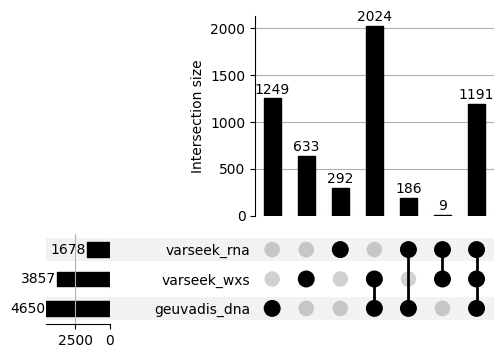

In [ ]:
variants_detected_data_for_upset = from_contents(data_type_to_detected_variants)
ax_dict = UpSet(variants_detected_data_for_upset, subset_size='count', show_counts=True).plot()
plt.savefig(os.path.join(out_dir, f"upset_variants_detected_sample_{sample_title}_w{w}_k{k}.pdf"))

In [ ]:
# haplotypecaller_script = os.path.join(RLSRP_2025_dir, "scripts", "run_gatk_haplotypecaller_for_benchmarking.py")
# fastq1 = ""
# fastq2 = ""

# reference_genome_fasta = "data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.dna.primary_assembly.fa"
# reference_genome_gtf = "data/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.87.gtf"
# genomes1000_vcf = "data/reference/ensembl_grch37_release93/1000GENOMES-phase_3.vcf"
# star_genome_dir = "data/reference/ensembl_grch37_release93/star_reference"
# cosmic_tsv = "data/reference/cosmic/CancerMutationCensus_AllData_Tsv_v101_GRCh37/CancerMutationCensus_AllData_v101_GRCh37.tsv"

# read_length = 75
# threads = 16

# java = "/home/jmrich/opt/jdk-17.0.12+7/bin/java"
# picard_jar = "/home/jmrich/opt/picard.jar"

# !python {haplotypecaller_script} \
# --synthetic_read_fastq {fastq1} \
# --synthetic_read_fastq2 {fastq2} \
# --out tmp \
# --reference_genome_fasta {reference_genome_fasta} \
# --reference_genome_gtf {reference_genome_gtf} \
# --genomes1000_vcf {genomes1000_vcf} \
# --star_genome_dir {star_genome_dir} \
# --java {java} \
# --picard_jar {picard_jar} \
# --threads {threads} \
# --read_length {read_length} \
# --disable_tool_default_read_filters \
# --skip_accuracy_analysis